### 온열질환자 구간에 따른 Classification 모델 생성

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import shap

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
import os
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectPercentile
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, Normalizer, LabelEncoder, label_binarize
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from itertools import cycle

In [2]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.utils import compute_class_weight
from keras.models import Sequential
from keras.layers import SimpleRNN, LSTM, Dense

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [3]:
# 나눔 폰트 경로 설정
# dir = '/data1/E382/hwchoi/00.data/00.preprocessing'
dir='C:/Windows/Fonts'
font_path = os.path.join(dir, 'NANUMGOTHIC.TTF')
# font_path = os.path.join(dir, 'DejaVu Sans')

# 폰트 속성 설정
fontprop = fm.FontProperties(fname=font_path, size=10)


# 폰트 매니저에 폰트 추가
fm.fontManager.addfont(font_path)

# Matplotlib 폰트 캐시 파일 삭제 (필요시 사용)
cache_dir = os.path.expanduser('~/.cache/matplotlib')
font_cache_path = os.path.join(cache_dir, 'fontlist-v330.json')
if os.path.exists(font_cache_path):
    os.remove(font_cache_path)

# 폰트를 matplotlib에 설정
plt.rc('font', family=fontprop.get_name())

###  MODELING

### XGBoost Classifier 진행

### SHAP을 이용해 추출한 TOP15개 feature를 이용한 분류 모델링 (Classifier)

In [4]:
path='D:/Work/002.code/jupyterNotebook/data/HEAT_TARGET/T_PATIENTS_DAILY_WHOLE_0812.csv'
df=pd.read_csv(path)
df.head(2)

performance_list = []

# create_date에 대한 sorting 적용
df['create_date'] = pd.to_datetime(df['create_date'])
df.sort_values(by='create_date', inplace=True)
# 결측치 채우기
df = df.fillna(0)

# class 1에 적합한 feature 리스트
features=['max_tafeel', 'ta_max_six_pm2', 'mean_wbtemp', 'popular_man', 'max_ta', 'popular_woman', 'max_wbtemp', 'ta_min_six_pm1', 'ta_mean_six_pm2', 'ta_mean_six_pm1'
        , 'mean_tafeel', 'agriculture_woman', 'agriculture_man', 'ta_max_six_am2', 'min_wbtemp']
target='jenks_cluster'
print(len(features))
print(features)

X=df[features]
y=df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, shuffle=True)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


df['binary_cluster'] = df['jenks_cluster'].apply(lambda x: 0 if x == 0 else 1)
print('binary 0/1 건수: ', df.groupby('binary_cluster').size())
print('multi 0/1/2 건수: ', df.groupby('jenks_cluster').size())

15
['max_tafeel', 'ta_max_six_pm2', 'mean_wbtemp', 'popular_man', 'max_ta', 'popular_woman', 'max_wbtemp', 'ta_min_six_pm1', 'ta_mean_six_pm2', 'ta_mean_six_pm1', 'mean_tafeel', 'agriculture_woman', 'agriculture_man', 'ta_max_six_am2', 'min_wbtemp']
binary 0/1 건수:  binary_cluster
0    19974
1     6036
dtype: int64
multi 0/1/2 건수:  jenks_cluster
0    19974
1     5538
2      498
dtype: int64


In [5]:
def plot_confusion_matrix(conf_matrix, model_name, accuracy):
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f'{model_name} Confusion Matrix\nAccuracy: {accuracy:.2f}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

In [6]:
performance_list = []
num_classes = 3

def evaluate_model(model, model_name, sample_weights):
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True, zero_division=1)
    confusion = confusion_matrix(y_test, y_pred)
    
    for cls in range(num_classes):
        cls = str(cls)
        performance_list.append({
            'Model': model_name,
            'Class': cls,
            'Accuracy': accuracy,
            'Precision': report[cls]['precision'],
            'Recall': report[cls]['recall'],
            'F1-Score': report[cls]['f1-score'],
            'Support': report[cls]['support']
        })
    
    plot_confusion_matrix(confusion, model_name, accuracy)

In [7]:
# 클래스 가중치 계산
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
sample_weights = np.array([class_weights[int(y)] for y in y_train])

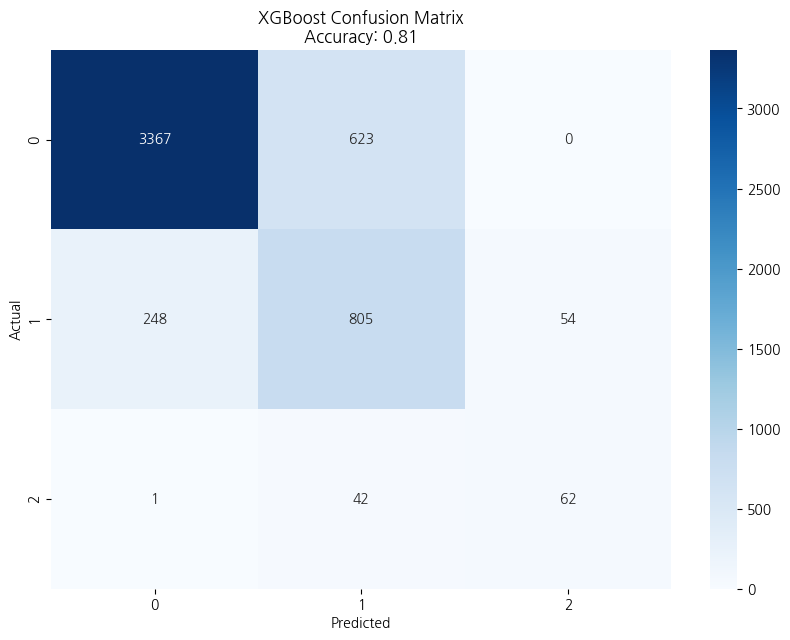

In [8]:
# XGBoost
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=11)
evaluate_model(xgb_classifier, 'XGBoost', sample_weights)

In [9]:
# 성능 데이터프레임 생성
performance_xgb = pd.DataFrame(performance_list)
print(performance_xgb)

     Model Class  Accuracy  Precision    Recall  F1-Score  Support
0  XGBoost     0  0.813918   0.931139  0.843860  0.885354   3990.0
1  XGBoost     1  0.813918   0.547619  0.727191  0.624757   1107.0
2  XGBoost     2  0.813918   0.534483  0.590476  0.561086    105.0


In [10]:
# 하이퍼파라미터 그리드 정의
param_grid = {
    'max_depth': [5, 10, 15],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [100, 200, 300],
    'subsample': [0.7, 0.8]
}

In [11]:
# XGBoost 모델과 GridSearchCV 설정
xgb_classifier = XGBClassifier(eval_metric='logloss', random_state=11)
grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='f1_macro', cv=3, n_jobs=-1, verbose=1)

# Grid Search 실행
grid_search.fit(X_train, y_train)

Fitting 3 folds for each of 54 candidates, totalling 162 fits


: 

In [ ]:
# 최적의 하이퍼파라미터 출력
print(f"Best Parameters: {grid_search.best_params_}")

# 최적의 모델로 예측 및 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Evaluation for Best XGBoost Model:")
print(classification_report(y_test, y_pred))

In [ ]:
# 혼동행렬 계산 및 시각화
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix for Best XGBoost Model")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### XGBoost Classfier Model 
#### Hyper parameter tunning

In [23]:
# 평가 함수 정의 (혼동행렬 시각화 포함)
def evaluate_model(model, model_name, X_train, X_test, y_train, y_test, sample_weights):
    model.fit(X_train, y_train, sample_weight=sample_weights)
    y_pred = model.predict(X_test)
    
    print(f"Evaluation for {model_name}:")
    print(classification_report(y_test, y_pred))
    
    # 혼동행렬 계산 및 시각화
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()
    print("="*60)

Evaluation for XGBoost (max_depth=10):
              precision    recall  f1-score   support

           0       0.91      0.90      0.90      3990
           1       0.60      0.63      0.62      1107
           2       0.55      0.56      0.56       105

    accuracy                           0.83      5202
   macro avg       0.69      0.70      0.69      5202
weighted avg       0.84      0.83      0.83      5202



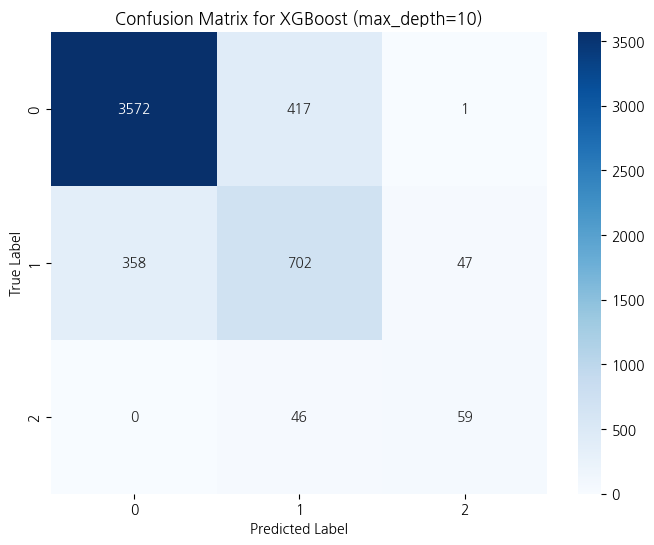

Evaluation for XGBoost (max_depth=15):
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3990
           1       0.62      0.60      0.61      1107
           2       0.59      0.56      0.58       105

    accuracy                           0.84      5202
   macro avg       0.70      0.69      0.70      5202
weighted avg       0.83      0.84      0.84      5202



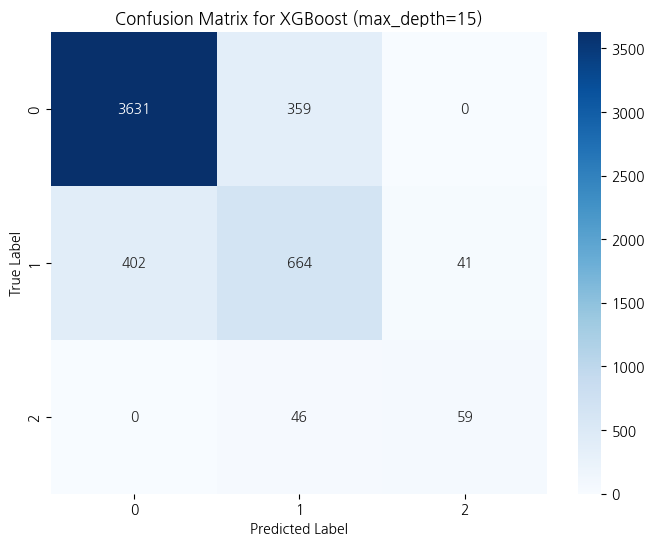

Evaluation for XGBoost (max_depth=20):
              precision    recall  f1-score   support

           0       0.90      0.91      0.91      3990
           1       0.63      0.60      0.61      1107
           2       0.59      0.55      0.57       105

    accuracy                           0.84      5202
   macro avg       0.71      0.69      0.70      5202
weighted avg       0.84      0.84      0.84      5202



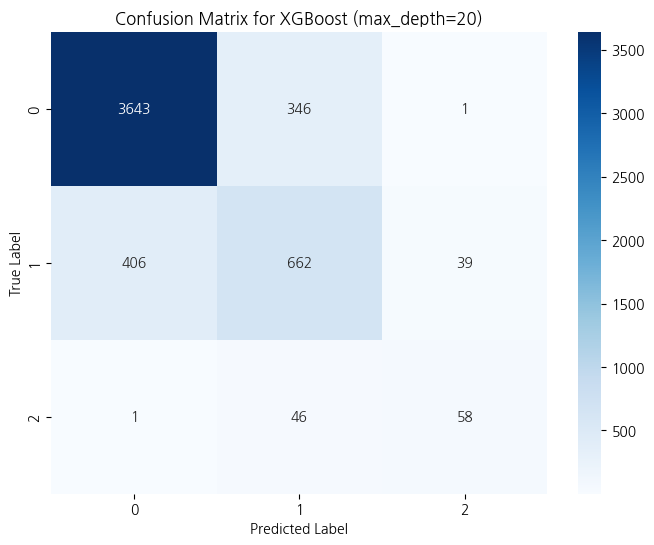

In [28]:
# 데이터 준비 (데이터셋 로드 및 전처리 코드는 생략합니다)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11)

# 다양한 파라미터 조합을 하드코딩
maxdept = [
    {"name": "XGBoost (max_depth=10)", "params": {"eval_metric": "logloss", "random_state": 11, "max_depth": 10}},
    {"name": "XGBoost (max_depth=15)", "params": {"eval_metric": "logloss", "random_state": 11, "max_depth": 15}},
    {"name": "XGBoost (max_depth=20)", "params": {"eval_metric": "logloss", "random_state": 11, "max_depth": 20}}
]

learning_rate = [
    {"name": "XGBoost (learning_rate=0.1)", "params": {"eval_metric": "logloss", "random_state": 11, "learning_rate": 0.1}},
    {"name": "XGBoost (learning_rate=0.1)", "params": {"eval_metric": "logloss", "random_state": 11, "learning_rate": 0.2}},
    {"name": "XGBoost (learning_rate=0.1)", "params": {"eval_metric": "logloss", "random_state": 11, "learning_rate": 0.3}}        
    # {"name": "XGBoost (subsample=0.8)", "params": {"eval_metric": "logloss", "random_state": 11, "subsample": 0.8}}
]

n_estimators=[
    {"name": "XGBoost (n_estimators=100)", "params": {"eval_metric": "logloss", "random_state": 11, "n_estimators": 50}},
    {"name": "XGBoost (n_estimators=100)", "params": {"eval_metric": "logloss", "random_state": 11, "n_estimators": 100}},
    {"name": "XGBoost (n_estimators=100)", "params": {"eval_metric": "logloss", "random_state": 11, "n_estimators": 150}}
]


# 각 파라미터 조합으로 모델 평가 및 혼동행렬 시각화
for model_dict in maxdept:
    model_name = model_dict["name"]
    model_params = model_dict["params"]
    xgb_classifier = XGBClassifier(**model_params)
    evaluate_model(xgb_classifier, model_name, X_train, X_test, y_train, y_test, sample_weights)